## Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from einops import rearrange
from collections import defaultdict
from functools import partial
import sys
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Embedding, Layer, BatchNormalization, Normalization, ReLU, Add
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal, Zeros
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import SparseCategoricalCrossentropy, Reduction
from tensorflow.keras import layers
import tensorflow_probability as tfp

from IPython import display
display.clear_output(wait=False)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [23]:
class CoinRunDataset:
    def __init__(self, data_dir, set='train', batch_size=32):
        self.data_dir = data_dir
        self.set = 'train'
        self.batch_size = batch_size
        self.filenames = os.listdir(data_dir)
        self.max_frames = 20
        self.a_width = 1
        
        self.data_length = len(self.filenames)
        print("Length of %s data: " % set, self.data_length)

    def __len__(self):
        return self.data_length

    def __iter__(self):
        for _ in range(0, self.data_length):
            file_idx = random.randint(0, self.data_length - 1)
            fname = self.filenames[file_idx]
            
            if not fname.endswith('npz'): 
                continue
    
            file_path = os.path.join(self.data_dir, fname)
            data = np.load(file_path)
            img = data['obs']

            video_length = img.shape[0]
            
            action = np.reshape(data['action'], newshape=[-1, self.a_width])
            reward = data['reward']
            done = data['done']
            N = data['N']
            
            offset = random.randint(0, video_length - self.max_frames - 1)
            offset = 0
            
            img = img[offset:offset + self.max_frames]
            action = action[offset:offset + self.max_frames]
            reward = reward[offset:offset + self.max_frames]
            done = done[offset:offset + self.max_frames]
            N = N[offset:offset + self.max_frames]

            yield img, action, reward, done, N

    __call__ = __iter__

data_dir = "record_single"
ds_gen = CoinRunDataset(data_dir=data_dir, set='train', batch_size=32)
ds = tf.data.Dataset.from_generator(ds_gen, (tf.float32, tf.float32, tf.float32, tf.bool, tf.int16))

Length of train data:  4400


In [24]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import animation
import random
import cv2
from IPython.display import HTML
from IPython import display

display.clear_output(wait=False)
for idx, data in enumerate(ds):
    video, action, reward, done, N = data
    break

fig = plt.figure()
plt.title('real (left), reconstruction (right)')
plt.axis('off')
im = plt.imshow(video[0, :, :, :])
plt.close()

def init():
    im.set_data(video[0, :, :, :])

def animate(i):
    im.set_data(video[i, :, :, :])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0], interval=200) # 200ms = 5 fps
#anim.save('dynamic_images.mp4')
HTML(anim.to_html5_video())

## Standalone VQ-VAE model

In [25]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.beta = beta

        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(shape=(self.embedding_dim, self.num_embeddings), dtype="float32"),
            trainable=True, name="embeddings_vqvae",
        )

    def get_code_indices(self, flattened_inputs):
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distance_1 = tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
        distance_2 = tf.reduce_sum(self.embeddings ** 2, axis=0) - 2 * similarity
        distances = distance_1 + distance_2
        encoding_indices = tf.argmin(distances, axis=1)
        
        return encoding_indices

    def call(self, x):
        input_shape = tf.shape(x)
        
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        encoding_indices = self.get_code_indices(flattened)

        encoding_indices_reshaped = tf.reshape(encoding_indices, [-1, 4, 4])
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        quantized = x + tf.stop_gradient(quantized - x)
        
        return quantized, encoding_indices_reshaped

In [26]:
class VQ_VAE(tf.keras.Model):
  def __init__(self, latent_dim, num_embeddings):
    super(VQ_VAE, self).__init__()

    self.latent_dim = latent_dim
    self.num_embeddings = num_embeddings

    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
            tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2D(latent_dim, 1, padding="same")
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(4, 4, 512)),
            tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"),
            tf.keras.layers.Conv2DTranspose(3, 3, padding="same")
        ]
    )

    self.vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")

  def call(self, inputs): 
    encoder_outputs = self.encoder(inputs)
    quantized_latents, encoding_indices_reshaped = self.vq_layer(encoder_outputs)   
    reconstructions = self.decoder(quantized_latents)

    return reconstructions, encoding_indices_reshaped

Note that the output channels of the encoder should match the `latent_dim` for the vector
quantizer.

In [27]:
latent_dim = 512
num_embeddings = 512
data_variance = 0.1
vqvae = VQ_VAE(latent_dim, num_embeddings)
vqvae.load_weights("model/CoinRun_VAVAQ_Model_60.ckpt")

encodings.shape:  (16, 512)
quantized.shape 1:  (16, 512)
quantized.shape 2:  (1, 4, 4, 512)
reconstructions.shape:  (1, 64, 64, 3)
reconstructions.shape:  (640, 640, 3)


Text(0.5, 1.0, 'reconstructions')

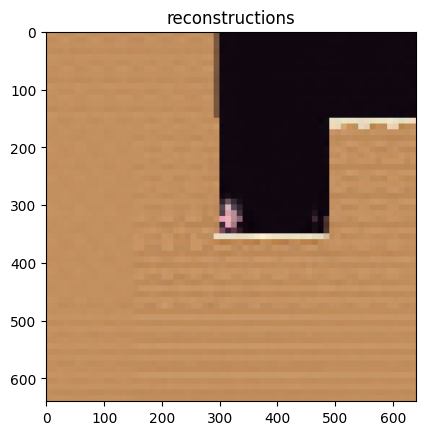

In [32]:
import cv2

obs_tokens = np.array([173, 150, 335,  66, 173, 390, 238, 134, 173, 173, 173, 134, 509, 509, 509, 134])

encodings = tf.one_hot(obs_tokens, vqvae.vq_layer.num_embeddings)
print("encodings.shape: ", encodings.shape)

quantized = tf.matmul(encodings, vqvae.vq_layer.embeddings, transpose_b=True)
print("quantized.shape 1: ", quantized.shape)

quantized = tf.reshape(quantized, [1, 4, 4, 512])
print("quantized.shape 2: ", quantized.shape)

reconstructions = vqvae.decoder(quantized)
print("reconstructions.shape: ", reconstructions.shape)

reconstructions = reconstructions.numpy()[0]
reconstructions = cv2.resize(reconstructions, dsize=(640, 640), interpolation=cv2.INTER_AREA)
print("reconstructions.shape: ", reconstructions.shape)

plt.imshow(reconstructions)
plt.title("reconstructions")

In [29]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

video.shape:  (20, 64, 64, 3)
image.shape:  (1, 64, 64, 3)
encoding_indices:  tf.Tensor([173 150 335  66 173 390 238 134 173 173 173 134 509 509 509 134], shape=(16,), dtype=int64)
reconstructions.shape:  (1, 64, 64, 3)


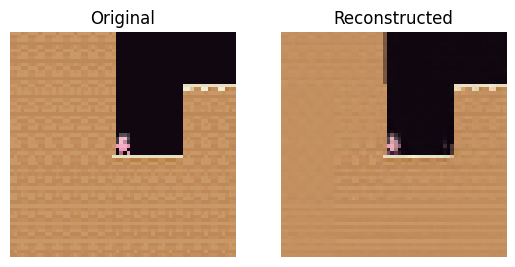

In [30]:
for epoch in range(0, 1000000):
    mean_loss = tf.keras.metrics.Mean()
    for idx, data in enumerate(ds):
        #print("idx: ", idx)
        video, action, reward, done, N = data
        print("video.shape: ", video.shape)

        image = video[0]
        image = tf.expand_dims(image, 0)
        print("image.shape: ", image.shape)
        
        #reconstructions = vqvae_trainer.vqvae(imgs)
        encoder_outputs = vqvae.encoder(image - 0.5)
        #tf.print("encoder_outputs.shape: ", encoder_outputs.shape)
        # encoder_outputs.shape:  (None, 7, 7, 16)
        
        quantized_latents, encoding_indices_reshaped = vqvae.vq_layer(encoder_outputs)
        #tf.print("quantized_latents.shape: ", quantized_latents.shape)
        # quantized_latents.shape:  (None, 7, 7, 16)

        #encoding_indices_reshaped = tf.reshape(encoding_indices, [-1, 4, 4])
        encoding_indices = tf.reshape(encoding_indices_reshaped, [-1, 16])
        
        encodings = tf.one_hot(encoding_indices, vqvae.vq_layer.num_embeddings)
        
        quantized = tf.matmul(encodings, vqvae.vq_layer.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, (1, 4, 4, 512))
        
        reconstructions = vqvae.decoder(quantized)
    
        print("reconstructions.shape: ", reconstructions.shape)

        for test_image, reconstructed_image in zip(image, reconstructions):
            show_subplot(test_image, reconstructed_image)
        
        break

    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022213826..0.9618331].


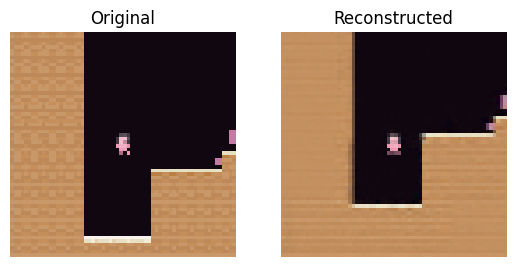

Epoch: 66, Test set ELBO: 0.02640954963862896, time elapse for current epoch: 315.7242982387543


KeyboardInterrupt: 

In [10]:
from IPython import display
import time

display.clear_output(wait=False)

optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(0, 10000):
    #print("epoch: ", epoch)
    start_time = time.time()
    mean_loss = tf.keras.metrics.Mean()
    for idx, data in enumerate(ds):
        #print("idx: ", idx)
        train_video, action, reward, done, N = data
        #print("video.shape: ", video.shape)

        #image = video[0]
        #image = tf.expand_dims(image, 0)
        
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions, _ = vqvae(train_video - 0.5)
    
            #print("imgs.shape: ", imgs.shape)
            #print("reconstructions.shape: ", reconstructions.shape)
            
            # Calculate the losses.
            reconstruction_loss = (tf.reduce_mean((train_video - reconstructions) ** 2) / data_variance)
            total_loss = reconstruction_loss + sum(vqvae.losses)

            #print("idx: {}, total_loss: {}".format(idx, total_loss))
            mean_loss(total_loss)

        # Backpropagation.
        grads = tape.gradient(total_loss, vqvae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vqvae.trainable_variables))

    elbo = mean_loss.result()
    end_time = time.time()

    for idx, data in enumerate(ds):
        # Test
        test_video, action, reward, done, N = data
        #print("test_video.shape: ", test_video.shape)
        
        idx = np.random.choice(test_video.shape[0])
        #print("idx: ", idx)
        
        test_image = test_video[idx] - 0.5
        test_image = np.expand_dims(test_image, 0)
        #print("test_batch_img.shape: ", test_batch_img.shape)
        
        encoder_outputs = vqvae.encoder(test_image)
        quantized_latents, encoding_indices_reshaped = vqvae.vq_layer(encoder_outputs)
    
        encoding_indices = tf.reshape(encoding_indices_reshaped, [-1, 16])
        encodings = tf.one_hot(encoding_indices, vqvae.vq_layer.num_embeddings)
        quantized = tf.matmul(encodings, vqvae.vq_layer.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, (1, 4, 4, 512))
            
        reconstructions = vqvae.decoder(quantized)
        #print("reconstructions.shape: ", reconstructions.shape)
    
        display.clear_output(wait=False)
        
        for test_image, reconstructed_image in zip(test_video, reconstructions):
            show_subplot(test_image, reconstructed_image)
            
        break

    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    
    if epoch % 10 == 0:
        vqvae.save_weights("model/CoinRun_VAVAQ_Model_{0}.ckpt".format(epoch))

In [ ]:
#vqvae_trainer.save_weights('model/model_vqvae.weights.h5')

## Reconstruction results on the test set

In [ ]:
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]

print("test_images.shape: ", test_images.shape)
reconstructions_test = trained_vqvae_model.predict(test_images)
print("reconstructions_test.shape: ", reconstructions_test.shape)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

These results look decent. You are encouraged to play with different hyperparameters
(especially the number of embeddings and the dimensions of the embeddings) and observe how
they affect the results.

## Visualizing the discrete codes

In [ ]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")
         
# test_images.shape:  (10, 28, 28, 1)

encoded_outputs = encoder.predict(test_images)
# encoded_outputs.shape:  (10, 7, 7, 16)

flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
# flat_enc_outputs.shape:  (490, 16)

codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
# codebook_indices.shape:  (490,)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
# codebook_indices.shape:  (10, 7, 7)

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()